# Solutions  Tutorial 5

We continue on the dataset of 'recreational fishing' mode.

The reference study, including a more detailed description of the dataset can be found [here](https://lib.dr.iastate.edu/cgi/viewcontent.cgi?article=1017&context=econ_las_pubs)

## Description of the dataset

Each row represents a different customer, customers are 'independent' of each other.

The variables in the dataset are:

**mode**: a categorical variable indicating the fishing model selected for the trip. It is encoded in numbers, with the code:
 1. Beach
 2. Pier
 3. Private boat
 4. Charter boat

**price_x**:  Cost of the fishing mode, variable in dollars. Where x stands for one of the alternatives, e.g. price_beach is the cost of the fishing from the beach in one fishing trip.

**catch_x**: Catch rate, in catches per hour. Where x stands for one of the alternatives, e.g. catch_beach is the catch rate of the beach alternative.

**income**: Monthly income of the recreational fisher, in dollars.


---
---

# Preparing the environment
*The preparation and dataset loading code is given to the students*

In [1]:
!pip install biogeme

Load the packages, feel free to change the names.

In [2]:
import pandas  as pd
import numpy as np
import matplotlib.pyplot as plt

import biogeme.database as db
import biogeme.biogeme as bio
import biogeme.models as models
import biogeme.expressions as exp
import biogeme.tools as tools

# Load the dataset

In [3]:
path = 'https://raw.githubusercontent.com/pmontman/pub-choicemodels/main/data/fishing.csv'
fish_pd = pd.read_csv(path)

A simple look at the dataset.

In [4]:
fish_pd.head(5)

,mode,price_beach,price_pier,price_boat,price_charter,catch_beach,catch_pier,catch_boat,catch_charter,income
0,4,157.930,157.930,157.930,182.930,0.0678,0.0503,0.2601,0.5391,7083.3317
1,4,15.114,15.114,10.534,34.534,0.1049,0.0451,0.1574,0.4671,1249.9998
2,3,161.874,161.874,24.334,59.334,0.5333,0.4522,0.2413,1.0266,3749.9999
3,2,15.134,15.134,55.930,84.930,0.0678,0.0789,0.1643,0.5391,2083.3332
4,3,106.930,106.930,41.514,71.014,0.0678,0.0503,0.1082,0.3240,4583.3320


---
---

# Auxiliary functions

The first function takes the dictionary of utilities, a pandas dataframe, and the name of the variable that contains the variable with the results of the choice. It returns the biogeme object with the model and the estimated 'results' object (the one we get the values, likelihoods, etc.)
We have added the dictionary with the utilities to the biogeme object, in case we use it later.

In [5]:
def qbus_estimate_bgm(V, pd_df, tgtvar_name, modelname='bgmdef'):
 av_auto = V.copy()
 for key, value in av_auto.items():
   av_auto[key] = 1
 bgm_db = db.Database(modelname + '_db', pd_df)
 globals().update(bgm_db.variables)
 logprob = models.loglogit (V , av_auto , bgm_db.variables[tgtvar_name] )
 bgm_model = bio.BIOGEME ( bgm_db, logprob )
 bgm_model.utility_dic = V.copy()
 return bgm_model, bgm_model.estimate()

The next function will calculate the predictions for a given biogeme object that was estimated with `qbus_estimate_bgm`. The output is the array with the choice probabilities. From the choice probabilities, this can be used to calculate accuracies, confusion matrices and the output of what-if scenarios.

In [6]:
def qbus_simulate_bgm(qbus_bgm_model, betas, pred_pd_df):
  av_auto = qbus_bgm_model.utility_dic.copy()
  for key, value in av_auto.items():
   av_auto[key] = 1

  targets = qbus_bgm_model.utility_dic.copy()
  for key, value in targets.items():
   targets[key] = models.logit(qbus_bgm_model.utility_dic, av_auto, key)

  bgm_db = db.Database('simul', pred_pd_df)
  globals().update(bgm_db.variables)
  bgm_pred_model = bio.BIOGEME(bgm_db, targets)
  simulatedValues = bgm_pred_model.simulate(betas)
  return simulatedValues

The function `qbus_calc_accu_confusion` calculates the accuracies given the choice probability predictions a pandas dataset and the specification of the name that contains the actual choices in the input dataset.

In [7]:
def qbus_calc_accu_confusion(sim_probs, pd_df, choice_var):
  which_max = sim_probs.idxmax(axis=1)
  data = {'y_Actual':   pd_df[choice_var],
          'y_Predicted': which_max
        }

  df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
  confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])
  accu = np.mean(which_max == pd_df[choice_var])
  return accu, confusion_matrix

The next function calculates the likelihood ratio test having to write a bit less code that the default biogeme function. The arguments are the results objects of the two models to be compared. The first is the more complex and the second is the reference model (**the order is important!**). The third argument is the significance level for the test.

In [8]:
def qbus_likeli_ratio_test_bgm(results_complex, results_reference, signif_level):
  return tools.likelihood_ratio_test( (results_complex.data.logLike, results_complex.data.nparam),
                                     (results_reference.data.logLike, results_reference.data.nparam), signif_level)

The next function just updates the globals so we can use it

In [9]:
def qbus_update_globals_bgm(pd_df):
   globals().update(db.Database('tmp_bg_bgm_for_glob', pd_df).variables)

---
---

# Estimating the models from previous tutorial, just to get them as reference

In [10]:
ASC_beach = exp.Beta ( 'ASC_beach' ,0, None , None ,0)
ASC_pier = exp.Beta ( 'ASC_pier' ,0, None , None ,0)
ASC_boat = exp.Beta ( 'ASC_boat' ,0, None , None ,0)
ASC_charter = exp.Beta ( 'ASC_charter' ,0, None , None ,1)
B_price = exp.Beta ( 'B_price' ,0, None , None ,0)
B_catch = exp.Beta ( 'B_catch' ,0, None , None ,0)

We need to update the globals of the python environment so we can later define the utilities directly.

In [11]:
qbus_update_globals_bgm(fish_pd)

We define the observed utilities functional forms and create the dictionary that groups them together and assign each one to the number that identifies each alternative in the dataset.

In [12]:
V_beach = ASC_beach + B_price*price_beach + B_catch*catch_beach
V_pier = ASC_pier + B_price*price_pier + B_catch*catch_pier
V_boat = ASC_boat + B_price*price_boat + B_catch*catch_boat
V_charter = ASC_charter + B_price*price_charter + B_catch*catch_charter

V_base = {1: V_beach,
     2: V_pier,
     3: V_boat,
     4: V_charter}

The estimate the model using our auxiliary function. We pass the utilities dictionary, the pandas dataframe with the data and the name of the variable in the dataframe that contains the choices. The fourth argument is optional and indicates the name for the model.
The output will be two objects, the biogeme object and the results object.

In [13]:
model_base, results_base = qbus_estimate_bgm(V_base, fish_pd, 'mode', 'fish')

You have not defined a name for the model. The output files are named from the model name. The default is [biogemeModelDefaultName]


In [14]:
results_base.getEstimatedParameters()

,Value,Rob. Std err,Rob. t-test,Rob. p-value
ASC_beach,-1.498888,0.129703,-11.556273,0.000000e+00
ASC_boat,-0.627513,0.116828,-5.371252,7.819192e-08
ASC_pier,-1.191833,0.128328,-9.287411,0.000000e+00
B_catch,0.377169,0.119247,3.162912,1.561997e-03
B_price,-0.024790,0.002329,-10.645099,0.000000e+00


In [15]:
results_base.getBetaValues()['B_catch'] / results_base.getBetaValues()['B_price']

-15.214835110048982

---
---
# Per alternative parameters and log transform

In [59]:
fish_adv = fish_pd.copy()
fish_adv['log_income'] = np.log(fish_adv['income'])
fish_adv['log_income'].describe()

count    1182.000000
mean        8.130302
std         0.659004
min         6.032287
25%         7.641724
50%         8.229511
75%         8.597236
max         9.433484
Name: log_income, dtype: float64

In [60]:
B_price_beach = exp.Beta ( 'B_price_beach' ,0, None , None ,0)
B_price_pier = exp.Beta ( 'B_price_pier' ,0, None , None ,0)
B_price_boat = exp.Beta ( 'B_price_boat' ,0, None , None ,0)
B_price_charter = exp.Beta ( 'B_price_charter' ,0, None , None ,0)

B_catch_beach = exp.Beta ( 'B_catch_beach' ,0, None , None ,0)
B_catch_pier = exp.Beta ( 'B_catch_pier' ,0, None , None ,0)
B_catch_boat = exp.Beta ( 'B_catch_boat' ,0, None , None ,0)
B_catch_charter = exp.Beta ( 'B_catch_charter' ,0, None , None ,0)

B_log_income_beach = exp.Beta ( 'B_log_income_beach' ,0, None , None ,0)
B_log_income_pier = exp.Beta ( 'B_log_income_pier' ,0, None , None ,0)
B_log_income_boat = exp.Beta ( 'B_log_income_boat' ,0, None , None ,0)
B_log_income_charter = exp.Beta ( 'B_log_income_charter' ,0, None , None ,0)


In [61]:
qbus_update_globals_bgm(fish_adv)

In [62]:

V_beach_adv = ASC_beach + B_price_beach*price_beach + B_catch_beach*catch_beach + B_log_income_beach*log_income
V_pier_adv = ASC_pier + B_price_pier*price_pier + B_catch_pier*catch_pier + B_log_income_pier*log_income
V_boat_adv = ASC_boat + B_price_boat*price_boat + B_catch_boat*catch_boat + B_log_income_boat*log_income
V_charter_adv = ASC_charter + B_price_charter*price_charter + B_catch_charter*catch_charter + B_log_income_charter*log_income

V_adv = {1: V_beach_adv,
     2: V_pier_adv,
     3: V_boat_adv,
     4: V_charter_adv}

In [63]:
model_adv, results_adv = qbus_estimate_bgm(V_adv, fish_adv, 'mode', 'fish_adv')

You have not defined a name for the model. The output files are named from the model name. The default is [biogemeModelDefaultName]


In [64]:
results_adv.getEstimatedParameters()

,Value,Rob. Std err,Rob. t-test,Rob. p-value
ASC_beach,-7.169392,1.626038,-4.409117,1.037931e-05
ASC_boat,-4.336756,1.012195,-4.284507,1.831447e-05
ASC_pier,-2.833458,1.315026,-2.154679,3.118696e-02
B_catch_beach,4.906212,0.865559,5.668257,1.442574e-08
B_catch_boat,2.463934,0.454626,5.419692,5.970179e-08
B_catch_charter,0.759886,0.138580,5.483371,4.172961e-08
B_catch_pier,4.795856,0.912223,5.257328,1.461632e-07
B_log_income_beach,0.383603,0.134637,2.849171,4.383330e-03
B_log_income_boat,0.089296,0.106886,0.835424,4.034788e-01
B_log_income_charter,-0.398227,0.090825,-4.384548,1.162270e-05


In [65]:
qbus_likeli_ratio_test_bgm(results_adv, results_base, 0.95)

LRTuple(message='H0 can be rejected at level 95.0%', statistic=127.03194550084709, threshold=3.940299136119061)

---
---

# 1) Nested logit estimation, according to the linear model especification in (Herriges et al. 1999).

First, we define a new variable, we will call it 'budget' which is `income - price`. Is it an attribute of the alternative or a socieconomic characteristic of the individuals?

We also see that there parameters will be shared among all alternatives, as in our basic reference model.

In [66]:
fish_nest = fish_pd.copy()
fish_nest['budget_beach'] = fish_nest['income'] - fish_pd['price_beach']
fish_nest['budget_pier'] = fish_nest['income'] - fish_pd['price_pier']
fish_nest['budget_boat'] = fish_nest['income'] - fish_pd['price_boat']
fish_nest['budget_charter'] = fish_nest['income'] - fish_pd['price_charter']
qbus_update_globals_bgm(fish_nest)

We define the new coefficients for biogeme




We define the utility functions

In [67]:
B_budget_nest = exp.Beta ( 'B_budget_nest' ,0, None , None ,0)

V_beach_nest = ASC_beach + B_budget_nest*budget_beach + B_catch*catch_beach
V_pier_nest = ASC_pier + B_budget_nest*budget_pier + B_catch*catch_pier
V_boat_nest = ASC_boat + B_budget_nest*budget_boat + B_catch*catch_boat
V_charter_nest = ASC_charter + B_budget_nest*budget_charter + B_catch*catch_charter

V_nest = {1: V_beach_nest,
     2: V_pier_nest,
     3: V_boat_nest,
     4: V_charter_nest}

We will create a new auxiliary function for estimating the nested logit, it is very similar to the one for the multinomial logit. It has an additional argument, the nest tuple, that we will define in the next cells.

In [68]:
def qbus_estimate_nested_bgm(V, pd_df, nests,  tgtvar_name, modelname='bgmdef'):
 av_auto = V.copy()
 for key, value in av_auto.items():
   av_auto[key] = 1
 bgm_db = db.Database(modelname + '_db', pd_df)
 globals().update(bgm_db.variables)
 logprobnest = models.lognested (V, av_auto , nests , bgm_db.variables[tgtvar_name] )
 #logprob = models.loglogit (V , av_auto , bgm_db.variables[tgtvar_name] )
 bgm_model = bio.BIOGEME ( bgm_db, logprobnest )
 bgm_model.utility_dic = V.copy()
 bgm_model.nest_tuple = nests
 return bgm_model, bgm_model.estimate()

The nest structure, **the new concept that we need to understand!**
If you remember, in the nested logit model, **we the analysts have to specify the nesting structure**. Then the strength of the nesting is estimated from the data, via a $\lambda$ parameter that went from 0 to 1. 0 implies complete nesting, 1 reduces to the multinomial logit. In biogeme, we use the same concept, but expressed in a different form. Instead of using the $lambda$ we will use a $\mu$ or grouping strength parameter. The relationship is $$\lambda = \frac{1}{\mu}$$

We want to create the grouping structure named 'charter' in the paper.

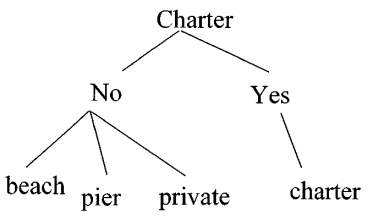

We will call the $mu$ parameter using the prefix `MU_`, simular to the $\beta$s using the prefix `B_`.
We declare it as another expression, using the `exp.Beta` from Biogeme. Yes it is a bit confusing, because biogeme uses the term Beta for all types of parameters that are estimated in the model, not only for the proper $\beta$s.

In [69]:

MU_NONCHART = exp.Beta('MU_NONCHART', 1, 1, 100, 0)


The last piece required by biogeme is the creating of the nest structure.Similar to the dictionary that maps utility functions to the alternative identifications, we need to specify which alternatives are affected by the mu grouping parameter. In biogeme, this is done via a tuple, one element is the parameter and the second is the list of alternatives that are affected by the grouping.
In the following cell, we create a grouping for beach (alt. 1), pier (alt. 2) and private boat (alt. 3). This is the grouping that will be affected by the `MU_NONCHART`. Other group, in this case it is only formed by the charter boat.
Since there is only one altenative in the group, we can set its grouping parameter to 1.
Finaly we put all tuples together to create the full grouping specification that is passed to biogeme.

In [70]:

nonchart_nest = MU_NONCHART, [1, 2, 3]
chart_nest = 1.0, [4]
nests_charter = nonchart_nest, chart_nest

Then we will estimate and check the model parameters.

In [71]:
model_nest, results_nest = qbus_estimate_nested_bgm(V_nest, fish_nest, nests_charter, 'mode', 'fish_nest' )

You have not defined a name for the model. The output files are named from the model name. The default is [biogemeModelDefaultName]
Numerical problem with the second derivative matrix. Norm = inf. Replaced by the BFGS approximation.
Numerical problem with the second derivative matrix. Norm = inf. Replaced by the BFGS approximation.
Numerical problem with the second derivative matrix. Norm = inf. Replaced by the BFGS approximation.
Numerical problem with the second derivative matrix. Norm = inf. Replaced by the BFGS approximation.
Numerical problem with the second derivative matrix. Norm = inf. Replaced by the BFGS approximation.
Numerical problem with the second derivative matrix. Norm = inf. Replaced by the BFGS approximation.
Numerical problem with the second derivative matrix. Norm = inf. Replaced by the BFGS approximation.
Numerical problem with the second derivative matrix. Norm = inf. Replaced by the BFGS approximation.
Numerical problem with the second derivative matrix. Norm = 

The estimation of the model gives similar coefficients to the paper.

In [72]:
results_nest.getEstimatedParameters()

,Value,Rob. Std err,Rob. t-test,Rob. p-value
ASC_beach,-0.391307,0.0,1.797693e+308,0.0
ASC_boat,-0.062768,0.0,1.797693e+308,0.0
ASC_pier,-0.241220,0.0,1.797693e+308,0.0
B_budget_nest,0.014043,0.0,1.797693e+308,0.0
B_catch,0.414533,0.0,1.797693e+308,0.0
MU_NONCHART,2.281242,0.0,1.797693e+308,0.0


The paper uses the $\lambda$ notation and so we can recover one from the other. We see that it is not exactly the same as the one in the paper.

In [73]:
1 / 2.28

0.4385964912280702

Testing for nested structure, we can do a likelihood ratio test w.r.t a simple model that sets the grouping strength parameter to 1, we would get a multinomial logit. We can do the likelihood ratio test because the nested logit is included in the multinomial, it has an additional parameter.

In [74]:
MU_NONCHART_base = exp.Beta('GRP_NONCHART_base', 1, 1, 100, 1)

nonchart_nest_base = MU_NONCHART_base, [1, 2, 3]
chart_nest = 1.0, [4]
nests_charter_base = nonchart_nest_base, chart_nest

In [75]:
model_nest_base, results_nest_base = qbus_estimate_nested_bgm(V_nest, fish_nest, nests_charter_base, 'mode', 'fish_nest' )

You have not defined a name for the model. The output files are named from the model name. The default is [biogemeModelDefaultName]


In [76]:
results_nest_base.getEstimatedParameters()

,Value,Rob. Std err,Rob. t-test,Rob. p-value
ASC_beach,-1.498888,0.129703,-11.556272,0.000000e+00
ASC_boat,-0.627513,0.116828,-5.371251,7.819216e-08
ASC_pier,-1.191833,0.128328,-9.287410,0.000000e+00
B_budget_nest,0.024790,0.002329,10.645097,0.000000e+00
B_catch,0.377169,0.119247,3.162911,1.561999e-03


In [77]:
qbus_likeli_ratio_test_bgm(results_nest, results_nest_base, 0.95)

LRTuple(message='H0 can be rejected at level 95.0%', statistic=27.929480545595197, threshold=0.003932140000019531)

We can compare to the MNL, we see that it is

In [78]:
model_mnl, results_mnl = qbus_estimate_bgm(V_nest, fish_nest, 'mode')

You have not defined a name for the model. The output files are named from the model name. The default is [biogemeModelDefaultName]


In [79]:
results_mnl.getEstimatedParameters()

,Value,Rob. Std err,Rob. t-test,Rob. p-value
ASC_beach,-1.498888,0.129703,-11.556272,0.000000e+00
ASC_boat,-0.627513,0.116828,-5.371251,7.819216e-08
ASC_pier,-1.191833,0.128328,-9.287410,0.000000e+00
B_budget_nest,0.024790,0.002329,10.645097,0.000000e+00
B_catch,0.377169,0.119247,3.162911,1.561999e-03


# Predictions



The predictions are equivalent to the MNL, we just have to do some minor changes and pass the nested structure around. We simplify this with an auxiliary function.

In [80]:
def qbus_simulate_nested_bgm(qbus_bgm_model, betas, pred_pd_df):
  av_auto = qbus_bgm_model.utility_dic.copy()
  for key, value in av_auto.items():
   av_auto[key] = 1

  targets = qbus_bgm_model.utility_dic.copy()
  for key, value in targets.items():
   targets[key] = models.nested(qbus_bgm_model.utility_dic, av_auto, qbus_bgm_model.nest_tuple, key)

  bgm_db = db.Database('simul', pred_pd_df)
  globals().update(bgm_db.variables)
  bgm_pred_model = bio.BIOGEME(bgm_db, targets)
  simulatedValues = bgm_pred_model.simulate(betas)
  return simulatedValues

In [81]:
pred_nests = qbus_simulate_nested_bgm(model_nest, results_nest.getBetaValues(), fish_nest)

In [82]:
pred_nests.head(5)

,1,2,3,4
0,0.124669,0.172690,0.316394,0.386248
1,0.123424,0.164262,0.317816,0.394498
2,0.003942,0.005141,0.518594,0.472323
3,0.231865,0.329983,0.145468,0.292683
4,0.028559,0.039560,0.510463,0.421417


In [83]:
pred_nests_base = qbus_simulate_nested_bgm(model_nest_base, results_nest_base.getBetaValues(), fish_nest)

In [84]:
pred_nests_base.head(5)

,1,2,3,4
0,0.128239,0.173183,0.329574,0.369003
1,0.121487,0.161468,0.331795,0.385250
2,0.007375,0.009724,0.477676,0.505224
3,0.237270,0.323902,0.213932,0.224896
4,0.037530,0.050683,0.460996,0.450791


# Exercise 0: Utilities and compensating values

We will study the 'compensating values' for the linear model. We start by creating an auxiliary function.

In [85]:
def qbus_simulate_nested_util_bgm(qbus_bgm_model, betas, pred_pd_df):
  av_auto = qbus_bgm_model.utility_dic.copy()
  for key, value in av_auto.items():
   av_auto[key] = 1

 # targets = qbus_bgm_model.utility_dic.copy()
 # for key, value in targets.items():
 #  targets[key] = models.nested(qbus_bgm_model.utility_dic, av_auto, qbus_bgm_model.nest_tuple, key)

  bgm_db = db.Database('simul', pred_pd_df)
  globals().update(bgm_db.variables)
  bgm_pred_model = bio.BIOGEME(bgm_db, qbus_bgm_model.utility_dic)
  simulatedValues = bgm_pred_model.simulate(betas)
  return simulatedValues

In [86]:
util_nest = qbus_simulate_nested_util_bgm(model_nest, results_nest.getBetaValues(), fish_nest)

Parameter MU_NONCHART not present in the model.


In [87]:
util_nest.head()

,1,2,3,4
0,96.891034,97.033867,97.299287,97.126632
1,16.993825,17.119123,17.408444,17.262558
2,50.218240,50.334708,52.357226,52.254017
3,28.680764,28.835453,28.476403,28.287287
4,62.499441,62.642274,63.763372,63.501324


The compensating values are defined as the increase/decrease in cost that compensates a change in utility that comes from modifying some attributes, another what if scenario. It is similar to the Willingness to pay.

## For the scenario of 'doubling catch rate', estimate the compensating values.

To estimate the compensating values, we have to calculate the utilities in the new setting (with double catch rate) and then estimate the increase in cost that will get the utility back to the level that it was in the reference scenario.

We can do this by simulation, this is, for each individual, we can try to find the increase in cost that makes the utility of the chose alternative in the new scenario be the same (or very close to) the reference. These are the compensating values.

The concept is similar to willingness to pay, which is defined as the increase in cost that compensates for and increase in a unit of another meaningful variable. In the case for this exercise (and the paper), instead of increasing the catch rate by one unit, we double all catch rates.

We start by creating the new scenario with double catch rate

In [88]:
fish_dbl_cv = fish_nest.copy()
fish_dbl_cv['catch_beach'] *=2
fish_dbl_cv['catch_pier'] *=2
fish_dbl_cv['catch_boat'] *=2
fish_dbl_cv['catch_charter'] *=2


For calculating the compensating values `cv` in the code, we will do a grid search, we will try several values of the increase in cost and take the one that makes the utility most similar to the reference scenario.

We start by adding some columns to the dataframe to store the cvs, and a `err_cv` column to keep track of which is the error of best compensating value in the grid, so when we try a new cv we know whether to update the best or not.

In [89]:
fish_dbl_cv['err_cv'] = 999999
fish_dbl_cv['cv'] = 0

The grid search is performed using a for loop, we will try for compensating values of up to 100 dollars, in a grid of incrementes of 1 dollar.
**Note that there are other ways of doing this calculation, particularly more exact or fast. However, this given enough computational powe this is a simple and general way of calculating the compensating values.**

In the loop, for each value of the cv that we try, we recalculate the budget variables and compute the utilities. The we compare the utilities of this scenario with the utilities of the reference scenario. Finally, we update the individuals for which the cv gets a utility more similar to the reference.

In [90]:
cost_range = np.linspace(0, 100, 101)
for cvc in cost_range:
 fish_dbl_cv['budget_beach'] = fish_dbl_cv['income'] - fish_dbl_cv['price_beach'] - cvc
 fish_dbl_cv['budget_pier'] = fish_dbl_cv['income'] - fish_dbl_cv['price_pier'] - cvc
 fish_dbl_cv['budget_boat'] = fish_dbl_cv['income'] - fish_dbl_cv['price_boat'] - cvc
 fish_dbl_cv['budget_charter'] = fish_dbl_cv['income'] - fish_dbl_cv['price_charter'] - cvc
 util_dbl_cv = qbus_simulate_nested_util_bgm(model_nest, results_nest.getBetaValues(), fish_dbl_cv)
 err_cv = np.abs(np.max(util_dbl_cv, 1) - np.max(util_nest, 1))
 fish_dbl_cv.loc[fish_dbl_cv['err_cv'] > err_cv, 'cv'] = cvc
 fish_dbl_cv.loc[fish_dbl_cv['err_cv'] > err_cv, 'err_cv'] = err_cv

Parameter MU_NONCHART not present in the model.
Parameter MU_NONCHART not present in the model.
Parameter MU_NONCHART not present in the model.
Parameter MU_NONCHART not present in the model.
Parameter MU_NONCHART not present in the model.
Parameter MU_NONCHART not present in the model.
Parameter MU_NONCHART not present in the model.
Parameter MU_NONCHART not present in the model.
Parameter MU_NONCHART not present in the model.
Parameter MU_NONCHART not present in the model.
Parameter MU_NONCHART not present in the model.
Parameter MU_NONCHART not present in the model.
Parameter MU_NONCHART not present in the model.
Parameter MU_NONCHART not present in the model.
Parameter MU_NONCHART not present in the model.
Parameter MU_NONCHART not present in the model.
Parameter MU_NONCHART not present in the model.
Parameter MU_NONCHART not present in the model.
Parameter MU_NONCHART not present in the model.
Parameter MU_NONCHART not present in the model.
Parameter MU_NONCHART not present in the

At the end of the loop, we should have the best value of the cv in the grid for each individual. We check the dataframe to validate the results the column 'cv' looks OK.

In [91]:
fish_dbl_cv.head()

,mode,price_beach,price_pier,price_boat,price_charter,catch_beach,catch_pier,catch_boat,catch_charter,income,budget_beach,budget_pier,budget_boat,budget_charter,err_cv,cv
0,4,157.930,157.930,157.930,182.930,0.1356,0.1006,0.5202,1.0782,7083.3317,6825.4017,6825.4017,6825.4017,6800.4017,0.004525,8
1,4,15.114,15.114,10.534,34.534,0.2098,0.0902,0.3148,0.9342,1249.9998,1134.8858,1134.8858,1139.4658,1115.4658,0.004968,5
2,3,161.874,161.874,24.334,59.334,1.0666,0.9044,0.4826,2.0532,3749.9999,3488.1259,3488.1259,3625.6659,3590.6659,0.000641,23
3,2,15.134,15.134,55.930,84.930,0.1356,0.1578,0.3286,1.0782,2083.3332,1968.1992,1968.1992,1927.4032,1898.4032,0.004620,2
4,3,106.930,106.930,41.514,71.014,0.1356,0.1006,0.2164,0.6480,4583.3320,4376.4020,4376.4020,4441.8180,4412.3180,0.002723,3


We compute the average of the individual cvs and we get a value that is in the range of what appears in the paper, so we have successfully compute the compensating values.

In [92]:
fish_dbl_cv['cv'].mean()

13.344331641285956

From here, we can calulate the sum to get an idea of the total impact in welfare of doubling the catch rate, measured in dollars.

In [93]:
fish_dbl_cv['cv'].sum()

15773

# Exercise 1) Change the nested structure to the 'private' in the paper and estimate the model, compare results to the other nesting structure.

We ahve to just redefine the nest structure.

In [94]:
MU_public = exp.Beta("MU_public", 1, 1, 100, 0)

public_nest = MU_public, [1, 2, 4]
private_nest = 1.0, [3]
nests_private = public_nest, private_nest

And then call the auxiliary function as usual, we will reuse the utility structure `V_nest` from before.

In [95]:
model_public, results_public = qbus_estimate_nested_bgm(V_nest, fish_nest, nests_private, 'mode', 'fish_private' )

You have not defined a name for the model. The output files are named from the model name. The default is [biogemeModelDefaultName]


In [96]:
results_public.getEstimatedParameters()

,Value,Rob. Std err,Rob. t-test,Rob. p-value
ASC_beach,-1.234409,0.308759,-3.997964,6.388965e-05
ASC_boat,-0.602376,0.110818,-5.435742,5.456893e-08
ASC_pier,-0.976892,0.259769,-3.760614,1.694968e-04
B_budget_nest,0.021708,0.004289,5.061556,4.158496e-07
B_catch,0.375105,0.111049,3.377837,7.305838e-04
MU_public,1.209162,0.279124,4.331995,1.477641e-05


In a likelihood ratio test, we see that the new nest structure is not significatively better than the other.

In [97]:
qbus_likeli_ratio_test_bgm(results_public, results_nest_base, 0.95)

LRTuple(message='H0 can be rejected at level 95.0%', statistic=1.5126859142001194, threshold=0.003932140000019531)

Taking a look at the values the coefficients in each model (the new nest structure is a couple of cells above), budget and catch rate have noticeably different values.

In [98]:
results_nest.getEstimatedParameters()

,Value,Rob. Std err,Rob. t-test,Rob. p-value
ASC_beach,-0.391307,0.0,1.797693e+308,0.0
ASC_boat,-0.062768,0.0,1.797693e+308,0.0
ASC_pier,-0.241220,0.0,1.797693e+308,0.0
B_budget_nest,0.014043,0.0,1.797693e+308,0.0
B_catch,0.414533,0.0,1.797693e+308,0.0
MU_NONCHART,2.281242,0.0,1.797693e+308,0.0


# Exercise 2) Estimate a nested model with per-alternative parameters and check if the nesting structure results in a better model.

We can reuse the utility functions declared for the multinomial logit `V_adv` in the notebook above, and then add the nesting structure. The we do a likelihood ratio test.

In [99]:
fish_nest['log_income'] = np.log(fish_nest['income'])

model_nest_adv, results_nest_adv = qbus_estimate_nested_bgm(V_adv, fish_nest, nests_private, 'mode', 'fish_private' )

You have not defined a name for the model. The output files are named from the model name. The default is [biogemeModelDefaultName]


In [100]:
results_nest_adv.getEstimatedParameters()

,Value,Rob. Std err,Rob. t-test,Rob. p-value
ASC_beach,-6.507050,2.049179,-3.175442,1.496082e-03
ASC_boat,-4.476301,1.039152,-4.307649,1.649990e-05
ASC_pier,-2.615679,1.328884,-1.968327,4.903040e-02
B_catch_beach,4.489759,1.249350,3.593676,3.260447e-04
B_catch_boat,2.315316,0.554651,4.174369,2.988137e-05
B_catch_charter,0.709868,0.169889,4.178419,2.935419e-05
B_catch_pier,4.389039,1.272112,3.450200,5.601721e-04
B_log_income_beach,0.332865,0.162429,2.049298,4.043300e-02
B_log_income_boat,0.125111,0.131043,0.954731,3.397138e-01
B_log_income_charter,-0.379967,0.095494,-3.978958,6.921806e-05


The test comes negative, adding nesting structure does not significatively improve the model.

In [101]:
qbus_likeli_ratio_test_bgm(results_nest_adv, results_adv, 0.95)

LRTuple(message='H0 can be rejected at level 95.0%', statistic=0.4589571383594375, threshold=0.003932140000019531)